In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir ./dataset
!unzip /content/drive/MyDrive/dataset/Test_1144.zip -d ./dataset

Archive:  /content/drive/MyDrive/dataset/Test_1144.zip
   creating: ./dataset/Test_1144/
   creating: ./dataset/Test_1144/high/
  inflating: ./dataset/Test_1144/high/0.npy  
  ... 
  inflating: ./dataset/Test_1144/mid/998.npy  
  inflating: ./dataset/Test_1144/mid/999.npy  


In [3]:
import cv2
import numpy as np
import os
import time
import random

import time

from torch import rand, manual_seed
from PIL import Image#, ImageFile
from IPython import display
from torch.optim import SGD, Adam, lr_scheduler
from torch import nn, FloatTensor, set_grad_enabled, save, uint8, cuda, device, no_grad, stack, mean
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, io, transforms
import torch
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

#ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
device = device('cuda:0' if cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
# https://didu-story.tistory.com/85
class FLIR_Data(Dataset):
  def __init__(self, LR_path, HR_path, transform, flip=False, grayscale=False):
    self.LR_data = LR_path
    self.HR_data = HR_path

    self.len = len(LR_path)
    self.transform = transform
    self.horizontalflip = transforms.RandomHorizontalFlip(p = 1)
    self.verticalflip = transforms.RandomVerticalFlip(p = 1)
    self.flip = flip    # True / False
    self.grayscale = grayscale  # True / False

  def __getitem__(self, index):
    image_LR = Image.fromarray(np.load(self.LR_data[index]))
    image_HR = Image.fromarray(np.load(self.HR_data[index]))
    if self.grayscale:
      image_LR = transforms.functional.to_grayscale(image_LR, num_output_channels=1)
      image_HR = transforms.functional.to_grayscale(image_HR, num_output_channels=1)
    
    #image_LR, image_HR = transforms.functional.rgb_to_grayscale(image_LR), transforms.functional.rgb_to_grayscale(image_HR)
    
    if self.flip:
      if rand(1) > 0.5:
          image_LR, image_HR = self.horizontalflip(image_LR), self.horizontalflip(image_HR)
      if rand(1) > 0.5:
          image_LR, image_HR = self.verticalflip(image_LR), self.verticalflip(image_HR)
    sample = self.transform(image_LR), self.transform(image_HR)
    return sample

  def __len__(self):
    return self.len

In [6]:
def total_params(model):
    total_params = sum(p.numel() for p in model.parameters()) # 그냥 묶어서 사용하자.
    return total_params

def make_file_list(path, size):
    r"""
    path -> file list with directory name
    size : size to include (오름차순 정렬된 상태 기준)
    """
    import os
    import natsort
    
    files : list = os.listdir(path)
    sorted_files = natsort.natsorted(files)

    if size == 0:
        return [path + '/' + file for file in sorted_files]

    else:
        return [path + '/' + file for file in sorted_files[:size]]

def pair_two_lists(list1, list2):
    r"""
    list1 = [x1, x2, x3], list2 = [y1, y2, y3]
    returns [(x1, y1), (x2, y2), (x3, y3)]
    """
    assert len(list1) == len(list2), 'list1 and list2 sizes are not same'
    
    return [(list1[i], list2[i]) for i in range(len(list1))]

def split_pairs(pairs):

    assert len(pairs[0]) == 2, 'pairs must be combined by two objects'

    result1 = []
    result2 = []

    for elem1, elem2 in pairs:
        result1.append(elem1)
        result2.append(elem2)

    return result1, result2

def random_split_by_ratio(pairs, train_test_ratio : list):
    r"""
    random_split_by_ratio(pairs : torch.Dataset, train_test_ratio = [train, test])
    ex) random_split_by_ratio(pairs, [0.8, 0.2]) # sum must be 1

    return : (train_images, test_images)
    """
    from torch.utils.data import random_split
    
    assert len(train_test_ratio) == 2, 'ratio list must be with two elements'
    assert train_test_ratio[0] + train_test_ratio[1] == 1, 'sum of ratio must be 1'

    train_size = int(len(pairs) * train_ratio)
    val_size = len(pairs) - train_size

    print(f"Train set size is {train_size}, Validation set size is {val_size}")

    return random_split(pairs, [train_size,val_size])

def normalize_ndarray_256(arr):

    min = arr.min()
    range = arr.max() - min

    if range > 0:
        normed_arr = 255 * (arr - min) / range
    else:
        normed_arr = arr

    return normed_arr

In [7]:
import math
from torch import nn
class FSRCNN(nn.Module):
    def __init__(self, scale_factor, num_channels=1, d=56, s=12, m=4):
        super(FSRCNN, self).__init__()
        self.first_part = nn.Sequential(
            nn.Conv2d(num_channels, d, kernel_size=5, padding=5//2),
            nn.PReLU(d)
        )

        self.mid_part1 = nn.Sequential(nn.Conv2d(d, s, kernel_size=1), nn.PReLU(s))
        self.mid_part2 = nn.Sequential(nn.Conv2d(s, s, kernel_size=3, padding=3//2), nn.PReLU(s))
        self.mid_part3 = nn.Sequential(nn.Conv2d(s, s, kernel_size=3, padding=3//2), nn.PReLU(s))
        self.mid_part4 = nn.Sequential(nn.Conv2d(s, s, kernel_size=3, padding=3//2), nn.PReLU(s))
        self.mid_part5 = nn.Sequential(nn.Conv2d(s, s, kernel_size=3, padding=3//2), nn.PReLU(s))
        self.mid_part6 = nn.Sequential(nn.Conv2d(s, d, kernel_size=1), nn.PReLU(d))

        self.last_part = nn.ConvTranspose2d(d, num_channels, kernel_size=9, stride=scale_factor, padding=9//2,
                                            output_padding=scale_factor-1)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.first_part:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)
        
        for mid_part in [self.mid_part1, self.mid_part2, self.mid_part3, self.mid_part4, self.mid_part5, self.mid_part6]:
            for m in mid_part:
              if isinstance(m, nn.Conv2d):
                  nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
                  nn.init.zeros_(m.bias.data)

        nn.init.normal_(self.last_part.weight.data, mean=0.0, std=0.001)
        nn.init.zeros_(self.last_part.bias.data)

    def forward(self, x):
        featuremap = []
        x = self.first_part(x)
        x = self.mid_part1(x)
        featuremap.append(x)
        x = self.mid_part2(x)
        x = self.mid_part3(x)
        x = self.mid_part4(x)
        featuremap.append(x)
        x = self.mid_part5(x)
        x = self.mid_part6(x)
        x = self.last_part(x)
        return featuremap, x

In [8]:
def total_params(model):
    total_params = sum(p.numel() for p in model.parameters()) # 그냥 묶어서 사용하자.
    return total_params

model_S0 = FSRCNN(scale_factor=4, num_channels=1)
model_S0.load_state_dict(torch.load('/content/drive/MyDrive/test_save/model_best_psnrfsrcnn_KD_b2_Lre-55_nt_nofe200.pt'))

model_S0 = model_S0.to(device)
print(total_params(model_S0))

12809


In [9]:
t1144_dir_LR = './dataset/Test_1144/low'
t1144_dir_HR = './dataset/Test_1144/high'
test_name_LR = make_file_list(t1144_dir_LR, 0)
test_name_HR = make_file_list(t1144_dir_HR, 0)
test_image = pair_two_lists(test_name_LR, test_name_HR)
test_image_LR, test_image_HR = split_pairs(test_image)
test_transform = transforms.Compose([transforms.ToTensor()])
test_data = FLIR_Data(test_image_LR, test_image_HR, test_transform, flip=False, grayscale=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=2)

INPUT IMAGE


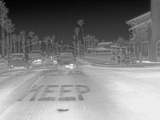

OUTPUT IMAGE


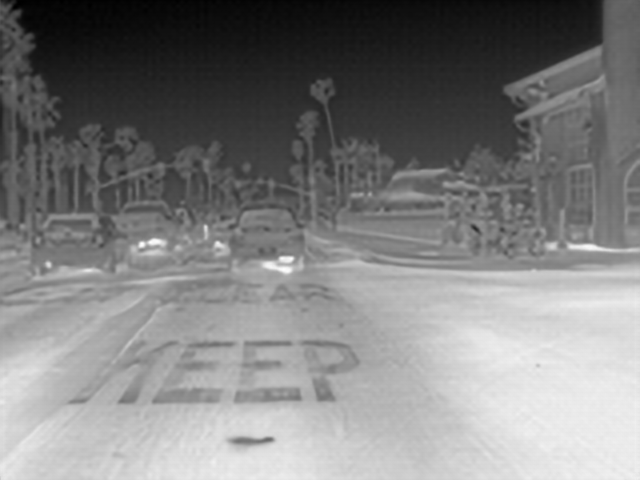

best PSNR: 29.120
best SSIM: 0.760
29.120447398014743
1144
Done!!!!


In [11]:
def evaluate_Re1(model):
    model.eval()  # setting the model to evaluate mode
    test_psnr = []
    test_ssim = []
    #model.load_state_dict(torch.load('./'+path+'model_best_psnr.pt'))

    for step, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # predicting
        with torch.no_grad():
            f, outputs = model(inputs)

            original = labels.detach().cpu().numpy()
            trained = outputs.detach().cpu().numpy()

            ori_norm = normalize_ndarray_256(original)
            tra_norm = normalize_ndarray_256(trained)

            ori_norm = ori_norm.astype(np.uint8).transpose((0, 2, 3, 1))
            aft_norm = tra_norm.astype(np.uint8).transpose((0, 2, 3, 1))

            if step % 30 == 0:
              original_input = inputs.detach().cpu().numpy()
              inp_norm = normalize_ndarray_256(original_input)
              inp_norm = inp_norm.astype(np.uint8).transpose((0, 2, 3, 1))

              display.clear_output(wait=True)
              print("INPUT IMAGE")
              display.display(Image.fromarray(inp_norm[0,:,:,0], 'L'))
              print("OUTPUT IMAGE")
              display.display(Image.fromarray(aft_norm[0,:,:,0], 'L'))

            for i in range(inputs.shape[0]):
                test_psnr.append(peak_signal_noise_ratio(ori_norm[i], aft_norm[i]))  # psnr of single image
                test_ssim.append(structural_similarity(ori_norm[i], aft_norm[i], full=True, multichannel=True)[0])
    print(f'best PSNR: {np.mean(test_psnr):.3f}')
    print(f'best SSIM: {np.mean(test_ssim):.3f}')
    print(sum(test_psnr)/len(test_psnr))
    print(len(test_psnr))

    print('Done!!!!')
    return 

evaluate_Re1(model_S0)